In [4]:
import numpy as np
import pandas as pd
import random
import torch
import math

In [5]:
class Value:

    def __init__(self, data, _children=(), _op='', label='', ):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other

    
    def __mul__(self, other):
        other = Value(other) if not isinstance(other, Value) else other
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other ** -1
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        x = self.data
        out = Value(x**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other*(x**(other-1)) * out.grad
        out._backward = _backward

        return out
        
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [6]:
class Neuron:

    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        #this is called when the instance of the class is called as n(x)

        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()

        return out

In [7]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.7371107049919492)

Layer of Neurons

In [8]:
class Layer:

    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

x = [2.0, 3.0]
l = Layer(2, 3)
l(x)

[Value(data=-0.9442889726598945),
 Value(data=-0.666518057369275),
 Value(data=0.6437409578929235)]

Multi Layers

In [9]:
class MLP:

    def __init__(self, n_in, n_outs):
        #nouts is a list which defines sizes of all layers in mlp
        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [10]:
x = [2.0, 3.0, 4.0]
n = MLP(3, [4, 4, 1])
n(x)


Value(data=-0.13627501352326785)

In [11]:
from graphviz import Digraph

def trace(root):
    "build a set of all nodes and edges in a graph"
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR is left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        #for any value in the graph, create a rectangular ('record') node

        dot.node(name = uid, label = "%s | data %.4f | grad %.4f" %(n.label, n.data, n.grad), shape ='record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            #connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
                 
    return dot

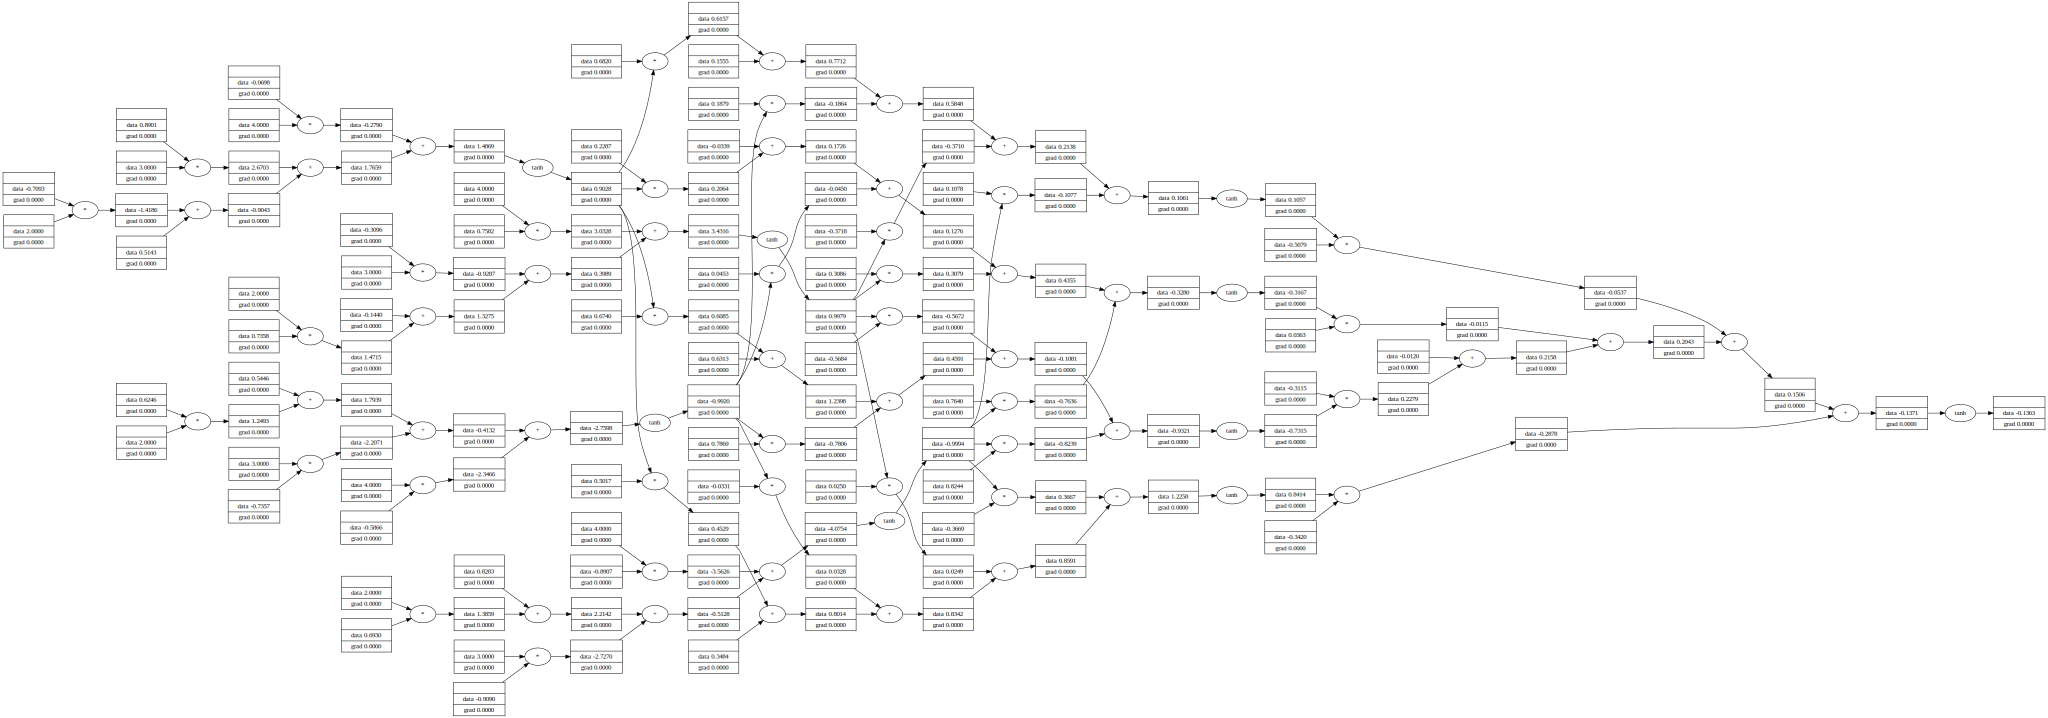

In [12]:
draw_dot(n(x))

Sample data

In [14]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [-1.0, -1.0, -1.0, 1.0] #targets

y_pred = [n(x) for x in xs]
y_pred

[Value(data=-0.7097948146398131),
 Value(data=0.20598269394909735),
 Value(data=-0.40135071968607866),
 Value(data=-0.6562120924488992)]

Loss Function

In [17]:
loss = sum([(out - tgt) for tgt, out in zip(ys, y_pred)])
loss

Value(data=0.4386250671743066)

In [18]:
loss.backward()

In [19]:
n.layers[0].neurons[0].w[0].grad

-0.26650793052600075

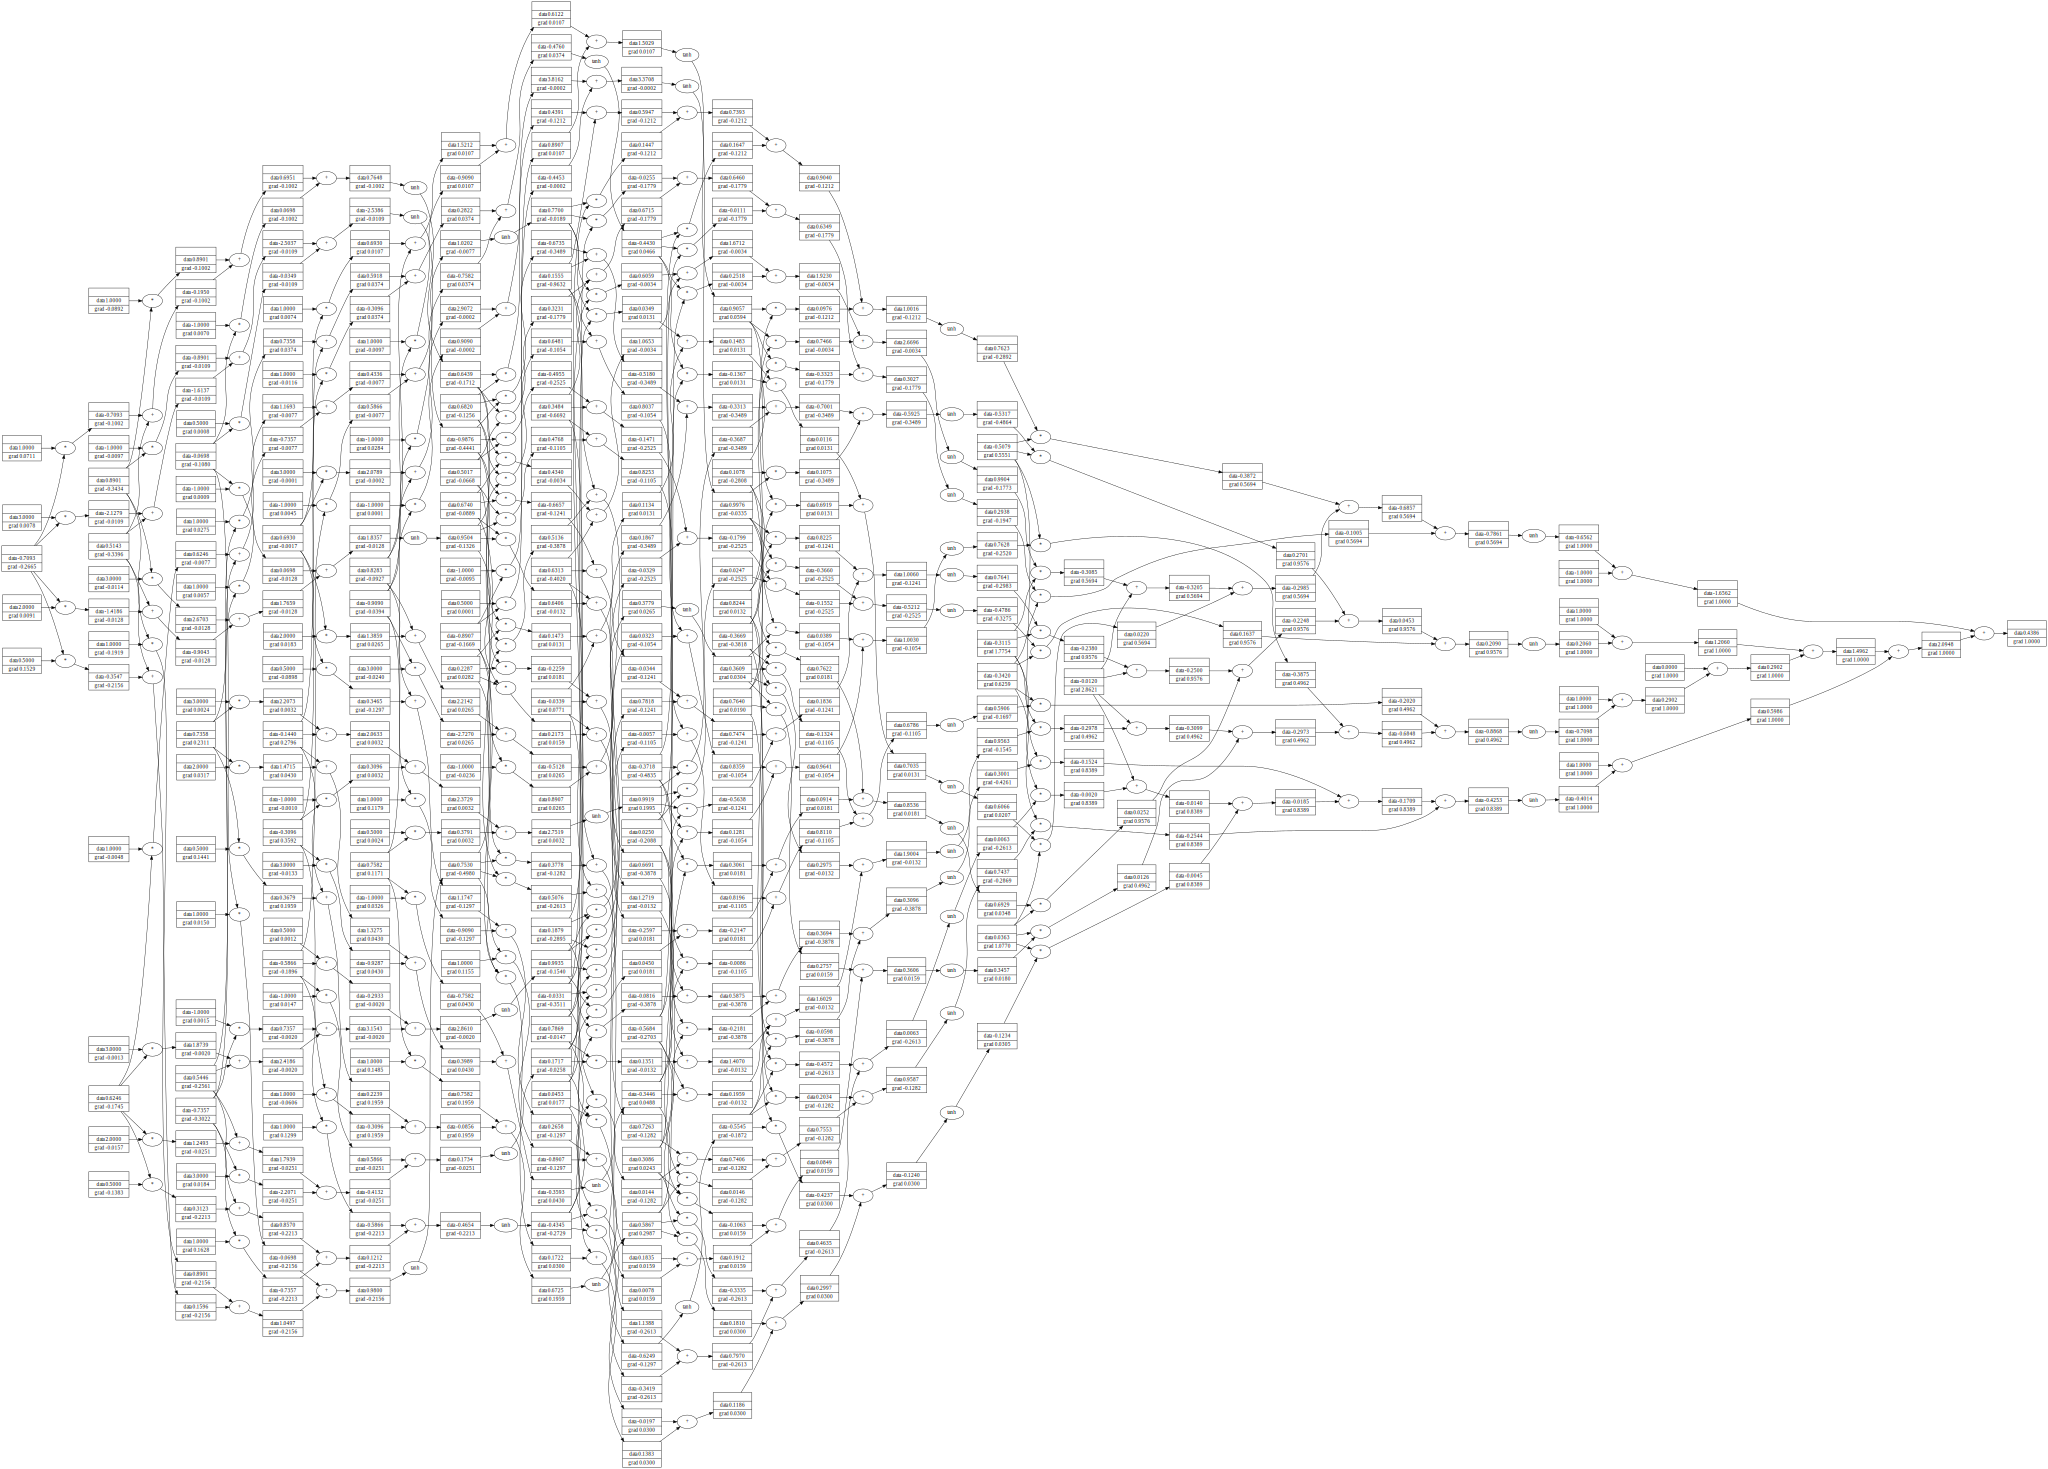

In [20]:
draw_dot(loss)

Implement params

In [21]:
class Neuron:

    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        #this is called when the instance of the class is called as n(x)

        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()

        return out
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:

    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [params for neuron in self.neurons for params in neuron.parameters()]

class MLP:

    def __init__(self, n_in, n_outs):
        #nouts is a list which defines sizes of all layers in mlp
        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(n_outs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [params for layer in self.layers for params in layer.parameters()]

In [23]:
x = [2.0, 3.0, 4.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7839312943682794)

In [24]:
n.parameters()

[Value(data=0.2866093721611134),
 Value(data=0.8759224832201307),
 Value(data=-0.25234824590536187),
 Value(data=0.7294758394650835),
 Value(data=0.6970389083690132),
 Value(data=-0.8861453864743714),
 Value(data=-0.7618783480494786),
 Value(data=0.039955810335811526),
 Value(data=-0.9655224465971237),
 Value(data=0.5208305219457507),
 Value(data=0.06487229621401558),
 Value(data=-0.7868166600218669),
 Value(data=-0.908678365173202),
 Value(data=0.5666715535189659),
 Value(data=0.6139337604608062),
 Value(data=0.05322461814789392),
 Value(data=0.6000407364477016),
 Value(data=0.20975056836739836),
 Value(data=0.9334793162015609),
 Value(data=-0.35465574087393525),
 Value(data=-0.4190073869746138),
 Value(data=0.7618361090353758),
 Value(data=-0.9074281198218654),
 Value(data=0.3047375404014607),
 Value(data=0.8324968630369489),
 Value(data=-0.49252106591126377),
 Value(data=-0.15489542926004884),
 Value(data=0.03892100270385468),
 Value(data=0.15301337853637031),
 Value(data=-0.6645487